In [13]:
import numpy as np
import networkx as nx
import random as rd
import math
import os
import matplotlib.pyplot as plt
import json

In [ ]:
class PoW:

    def __init__(self, ntwk, params):
        self.ntwk = ntwk
        self.N = len(ntwk)
        self.N_active = len([node for node in ntwk.nodes() if self.ntwk.nodes[node]["active"]])
        # Is the prev_block important here?
        self.global_blockchain = {0: {"level": 0, "prev_block": 0, "miner": -1, "time_created": 0, "n_transactions": 0, "children" : []}}
        self.global_levels = {0: [0]}
        self.total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        self.time = 0
        self.newest_block_id = 0
        self.signals = {}
        self.changed_blockchain_nodes = []
        self.params = params
        self.transaction_pool = 0
        self.activity_changes = 0
        self.measures = {
            "HHI" : [],
            "gini" : [],
            "entropy" : [],
            "naka" : [],
            "TPS" : [],
            "storage_ratio" : [],
            "fork_rate" : [],
            "fork_ratio" : [],
            "orphaned_ratio" : []
        }

    def randomSignalNoise(self):
        # Random Noise CANNOT be negative
        return np.random.poisson(self.params["avg_signal_noise"])

    def addNewTransactions(self):
        self.transaction_pool += np.random.poisson(self.params["avg_transaction_rate"])

    # Create number of transactions for nodes to add to the block they're mining on
    def getNumTransactions(self):
        return max(1, min(self.transaction_pool - np.random.poisson(4 * self.params["avg_transaction_rate"]), self.params["max_n_transactions"] - np.random.poisson(self.params["avg_transaction_rate"])))

    # Returns total power of all nodes
    def getTotalPower(self):
        return sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())

    # Returns total power of all active nodes currently
    def getTotalActivePower(self):
        return sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes() if self.ntwk.nodes[node]["active"])

    # Deciding whether to activate or deactivate a node
    # This can depend on several factors - power of node, whether they successfully mined a block, the reward and difficulty, and other things
    def nodeActivateOrDeactivate(self):
        for node in self.ntwk.nodes():
            if self.ntwk.nodes[node]["active"]:
                # Here, prob(deactivating) = q * (1 - x), where x is hashrate share
                if rd.random() < (1 - (self.ntwk.nodes[node]["power"]/self.total_power)) * self.params["deactivate"]:
                    self.ntwk.nodes[node]["active"] = False
                    self.N_active -= 1
                    self.activity_changes += 1
            else:
                # Here, prob(activating) = p * x + q, where x is hashrate share
                if rd.random() < (self.ntwk.nodes[node]["power"] * self.params["activate"])/self.total_power + self.params["deactivate"]:
                    self.ntwk.nodes[node]["active"] = True
                    self.N_active += 1
                    self.restartNode(node)
                    self.activity_changes += 1
            # Overall, prob(activating) > prob(deactivating) here for all values of params for all nodes.

    def sendSignal(self, node, block_id):
        # Send signal to all neighbors of node
        for nb in self.ntwk.neighbors(node):
            # Calculate arrival time of signal for neighbor "nb"
            arrival_time = self.time + round(self.global_blockchain[block_id]["n_transactions"]/self.ntwk[node][nb]["bandwidth"]) + self.randomSignalNoise()

            # Handle missing arrival_time and nb cases
            if not (arrival_time in self.signals):
                self.signals[arrival_time] = {}
            if not (nb in self.signals[arrival_time]):
                self.signals[arrival_time][nb] = []

            # Add block_id in "arrival_time" at correct neighbor "nb"
            self.signals[arrival_time][nb].append(block_id)

    # Adds the new block to both global and node's local blockchain and updates both global and node's local levels
    def addNewBlock(self, node):
        # Level to add newly mined block = Level of block that node was mining on + 1
        level = self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["level"] + 1
        # or, as it better be mining on longest chain block, level = max(list(self.ntwk.nodes[node]["local_levels"])) + 1

        # Creates new block and updates global_blockchain
        self.global_blockchain[self.newest_block_id] = {"level": level, "prev_block": self.ntwk.nodes[node]["mining"]["block_id"], "miner": node, "time_created": self.time, "n_transactions": self.ntwk.nodes[node]["mining"]["n_transactions"], "children" : []}
        
        # Subtract n_transactions away from transaction_pool
        self.transaction_pool -= self.ntwk.nodes[node]["mining"]["n_transactions"]

        # Adds itself to the "children" of its prev_block
        self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["children"].append(self.newest_block_id)
        
        # Updates global_levels
        if not (level in self.global_levels):
            self.global_levels[level] = []
        self.global_levels[level].append(self.newest_block_id)

        # Updates local_blockchain
        self.ntwk.nodes[node]["local_blockchain"][self.newest_block_id] = self.time

        # Updates local_levels (note that the condition must always be true, but I still added the "if" condition just in case)
        if not (level in self.ntwk.nodes[node]["local_levels"]):
            self.ntwk.nodes[node]["local_levels"][level] = []
        self.ntwk.nodes[node]["local_levels"][level].append(self.newest_block_id)

        # Adds node to changed_blockchain_nodes
        self.changed_blockchain_nodes.append(node)

    def verifyAddingBlockToNode(self, node, level, block_id) -> bool:
        if (level - 1) in self.ntwk.nodes[node]["local_levels"]:
            for block in self.ntwk.nodes[node]["local_levels"][level - 1]:
                if block == self.global_blockchain[block_id]["prev_block"]:
                    return True
        return False

    # CHANGE LOCAL BLOCKCHAIN TO ONLY HAVE BLOCK ID AND TIME IT RECEIVED IT
    def addBlockToLocalBlockchainFromSignal(self, node, block_id):
        level = self.global_blockchain[block_id]["level"]

        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

        else: # Adds block_id to storage with correct level key
            if not (level in self.ntwk.nodes[node]["storage"]):
                self.ntwk.nodes[node]["storage"][level] = []
            self.ntwk.nodes[node]["storage"][level].append(block_id)
            # Adding this node to changed_blockchain_nodes after a block has been added into its storage is unnecessary.
            # If and when a storage block does finally find a place to fit into the local blockchain,
            # That would only happen after the local blockchain has been changed by some block getting added in it,
            # And in that case, the node would be added into changed_blockchain_nodes anyway and the storage would get fixed.

    def tryAddBlockToLocalBlockchainFromStorage(self, node, level, block_id):
        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

            self.ntwk.nodes[node]["storage"][level].remove(block_id)
            
    # Handles mining
    def allMining(self):
        for node in self.ntwk.nodes():
            # Checks mining status of "node" and if it is active
            if self.time == self.ntwk.nodes[node]["mining"]["mine_time"] and self.ntwk.nodes[node]["active"]:
                # Increase newest block id by 1
                self.newest_block_id += 1
                # Add new block to global and local blockchains
                self.addNewBlock(node)
                # Send signal to all neighbors
                self.sendSignal(node, self.newest_block_id)

    def handleSignals(self):
        # If there exist signals supposed to arrive at current time
        if self.time in self.signals:
            # For all nodes supposed to receive those signals
            for node in self.signals[self.time]:
                # Add all blocks that the particular node was supposed to receive to the node local blockchain
                for block_id in self.signals[self.time][node]:
                    self.addBlockToLocalBlockchainFromSignal(node, block_id)
            # Free up memory by deleting the current time signals list
            del self.signals[self.time]

    # For a node, checks all block ids in storage and tries to add them in local blockchain
    def checkNodeStorage(self, node):
        levels = list(self.ntwk.nodes[node]["storage"].keys())
        levels.sort()
        for level in levels:
            for block_id in self.ntwk.nodes[node]["storage"][level]:
                self.tryAddBlockToLocalBlockchainFromStorage(node, level, block_id)

    # Checks if a node is mining on the longest chain block, and restarts it if it is not
    def checkNodeRestart(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]

        # If the block it is mining on isn't longest_chain_block_id, then restart mining on this new block
        if self.ntwk.nodes[node]["mining"]["block_id"] != longest_chain_block_id:
            self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # Restarts a node forcefully
    def restartNode(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]
        self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
        self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
        self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # For every changed blockchain nodes, checks its storage and whether it requires restart
    def checkNodes(self):
        for _ in range(len(self.changed_blockchain_nodes)):
            # Pop the node out to free up memory
            node = self.changed_blockchain_nodes.pop(0)
            self.checkNodeStorage(node)
            # You only need to restart if the node is active, as an inactive node becoming active will get restarted anyway
            if self.ntwk.nodes[node]["active"]: self.checkNodeRestart(node)

    def getLongestChain(self):
        longest_chain = []

        # Get longest chain block id, which is the first block in the highest global level
        block_id = self.global_levels[max(list(self.global_levels))][0]

        # WHY WAS THIS WRITTEN IN PLACE OF ABOVE BEFORE? IT HAS LOCAL LEVELS NOT GLOBAL, AND node VARIABLE ISN'T EVEN DEFINED
        # block_id = self.ntwk.nodes[node]["local_levels"][max(list(self.global_levels))][0]

        while block_id != 0:
            longest_chain.append(block_id)
            block_id = self.global_blockchain[block_id]["prev_block"]
        
        return longest_chain
 
    def getActivePowers(self):
        total_active_power = self.getTotalActivePower()
        power_values = [self.ntwk.nodes[node]["power"]/total_active_power for node in self.ntwk.nodes() if self.ntwk.nodes[node]["active"]]
        return power_values

    def topActivePowersSquaredSum(self, p):
        power_values = self.getActivePowers()
        power_values.sort(reverse=True)
        return sum(power**2 for power in power_values[:int(len(power_values)*p/100)])

    def measureHHI(self):
        return 1 - self.topActivePowersSquaredSum(10)

    def measureNaka(self):
        power_values = self.getActivePowers()
        power_values.sort(reverse=True)
        power_sum = 0
        i = 0
        while (power_sum < 0.51):
            power_sum += power_values[i]
            i += 1
        return i/self.N_active

    def measureEntropy(self):
        power_values = self.getActivePowers()
        return - sum(power * np.log2(power) for power in power_values)/np.log2(self.N_active)

    def measureGini(self):
        power_values = self.getActivePowers()
        gini = 0
        for i in range(self.N_active - 1):
            for j in range(i + 1, self.N_active):
                gini += abs(power_values[i] - power_values[j])
        return 1 - gini/self.N_active

    def measureTPS(self):
        # self.time will not be 0 as it is incremented to 1 at the start of the very first iteration
        return sum(self.global_blockchain[block_id]["n_transactions"] for block_id in self.getLongestChain())/self.time

    # Ratio of total number of blocks in storage across all nodes to total number of blocks
    def measureStorageRatio(self):
        if self.newest_block_id == 0 : return 0
        return sum(len(self.ntwk.nodes[node]["storage"][level]) for node in self.ntwk.nodes() for level in self.ntwk.nodes[node]["storage"])/self.newest_block_id

    # Two measures - Rate of forks; and Ratio of number of forks to total number of blocks
    def measureForkRateAndRatio(self):
        if self.newest_block_id == 0 : return {"rate" : 0, "ratio" : 0}
        func = lambda l : l - 1 if l >= 2 else 0
        forks = sum(func(len(self.global_blockchain[block_id]["children"])) for block_id in self.global_blockchain)
        return {"rate" : forks/self.time, "ratio" : forks/self.newest_block_id}

    # Ratio of number of orphaned blocks to total number of blocks
    def measureOrphanedBlocksRatio(self):
        if self.newest_block_id == 0 : return 0
        return (self.newest_block_id - len(self.getLongestChain()))/self.newest_block_id

    # Measure the distribution of lengths of chains that have been reverted and abandoned
    def measureRevertRate(self):
        pass

    # Check the consensus on blockchain - till when do they all agree and by how much?
    def measureConsensus(self):
        pass

    def runMeasures(self):
        self.measures["HHI"].append(self.measureHHI())
        self.measures["gini"].append(self.measureGini())
        self.measures["naka"].append(self.measureNaka())
        self.measures["entropy"].append(self.measureEntropy())
        self.measures["TPS"].append(self.measureTPS())
        self.measures["storage_ratio"].append(self.measureStorageRatio())
        fork_measures = self.measureForkRateAndRatio()
        self.measures["fork_rate"].append(fork_measures["rate"])
        self.measures["fork_ratio"].append(fork_measures["ratio"])
        self.measures["orphaned_ratio"].append(self.measureOrphanedBlocksRatio())

    def initializeNetwork(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["mining"] = {}
            self.ntwk.nodes[node]["mining"]["block_id"] = 0
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(np.random.exponential(self.params["avg_mine_time"] * self.getTotalActivePower()/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()
            self.ntwk.nodes[node]["local_blockchain"] = {0: 0}
            self.ntwk.nodes[node]["local_levels"] = {0: [0]}
            self.ntwk.nodes[node]["storage"] = {}

    def runSimulation(self):
        self.addNewTransactions()
        self.initializeNetwork()
        while (self.time < self.params["run_time"]):
            self.time += 1
            self.addNewTransactions()
            self.allMining()
            self.handleSignals()
            # self.measures() should go here as self.checkNodes() deletes some data like storage that self.measure() might need
            self.runMeasures()
            self.checkNodes()
            self.nodeActivateOrDeactivate()

In [ ]:
class RandomNetwork:

    def __init__(self, n):
        self.n = n
        self.folder = folder

    def createGraph(self):
        self.ntwk = nx.complete_graph(self.n)
        
    def assignPower(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["power"] = np.random.pareto(1.2) + 1

    def assignWeights(self):
        for edge in self.ntwk.edges:
            self.ntwk.edges[edge]["bandwidth"] = 100/np.random.lognormal(1,0.7)

    def assignActiveOrInactive(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["active"] = (np.random.random() < 0.25)

    def createNetwork(self):
        self.createGraph()
        self.assignPower()
        self.assignWeights()
        self.assignActiveOrInactive()
        self.getStats()

    def getStats(self):
        total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        print(f"Total Power : {total_power}")
        print(f"Max power : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Max power share : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Min power : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Min power share : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Max bandwidth : {max([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")
        print(f"Min bandwidth : {min([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")

    def writeNetwork(self):
        pass

    def getNetwork(self):
        return self.ntwk

# Create the Network

In [ ]:
class Network:

    def __init__(self, A, B, pareto_param, bandwidth_factor):
        self.A = A
        self.B = B
        self.X = np.array([[]])
        self.power = np.array([])
        self.pareto_param = pareto_param
        self.bandwidth_factor = bandwidth_factor
        self.bandwidth = {}
        self.activity = []

    def plotAll(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=self.power)
        plt.title("All Nodes")
        plt.xlim(0,self.A)
        plt.ylim(0,self.B)
        plt.show()

    def plotActive(self):
        for i in range(len(self.activity)):
            if self.activity[i]:
                plt.scatter(self.X[i][0], self.X[i][1])
                plt.title("Active Nodes")
                plt.xlim(0,self.A)
                plt.ylim(0,self.B)
                plt.show()

    def plotCheck(self, x, values):
        plt.scatter(x[:,0], x[:,1], c=values)
        plt.title("Check the Network")
        plt.xlim(0,self.A)
        plt.ylim(0,self.B)
        plt.show()

    def addPoints(self, num, a, b, seed):
        np.random.seed(seed)
        x = np.random.rand(num, 2)
        x[:,0] += a
        x[:,1] += b
        values = np.random.pareto(self.pareto_param, num) + 1
        self.plotCheck(x, values)
        inp1 = input("Continue? [y/n] : ")
        if ans == "y" or ans == "Y":
            self.X = np.concatenate((self.X, x))
            self.power = np.concatenate((self.power, values))
            print("Points added successfully!")
        else:
            print("Points rejected!")

    def assignBandwidth(self):
        for i in range(len(self.X) - 1):
            for j in range(i + 1, len(self.X)):
                self.bandwidth[(i,j)] = self.bandwidth_factor/np.linalg.norm(self.X[i] - self.X[j])

    def assignActivity(self):
        for _ in range(len(self.X)):
            self.activity.append((rd.random() < 0.25))

    def writePower(self):
        pass

    def writeBandwidth(self):
        pass

    def writeActivity(self):
        pass

In [26]:
ntwk = Network(100, 100, 1.2, 1000)

In [ ]:
def generateScatter(tier_nums):
    pass

In [15]:
class UniRnNtwkTriInqGenerator:

    def __init__(self, n, params, folder):
        self.n = n
        self.params = params
        self.folder = folder

    def generateScatter(self):
        np.random.seed(self.params["seed"])
        self.X = np.random.rand(self.n, 2)

    def assignPower(self):
        self.power = {}
        for i in range(self.n):
            self.power[i] = np.random.pareto(self.params["pareto"])

    def assignBandwidth(self):
        self.bandwidth = {}
        for i in range(self.n - 1):
            for j in range(i + 1, self.n):
                self.bandwidth[(i,j)] = self.params["bandwidth_factor"]/np.linalg.norm(self.X[i] - self.X[j])

    def assignActivity(self):
        self.activity = {}
        for i in range(self.n):
            self.activity[i] = (rd.random < self.params["active_prob"])

    def plotAll(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=list(self.power.values()))
        plt.title("All Nodes")
        plt.show()

    def plotActive(self):
        plt.scatter(self.X[:,0][self.activity], self.X[:,1][self.activity], c=np.array(list(self.power.values()))[self.activity])
        plt.title("Active Nodes")
        plt.show()

    def createNetwork(self):
        self.generateScatter()
        self.assignPower()
        self.assignBandwidth()
        self.assignActivity()

    def writeData(self):
        os.makedirs(f"Networks/{self.folder}", exist_ok=True)
        with open(f"Networks/{self.folder}/params_UniRnNtwkTriInqGenerator.json", "w") as outfile:
            json.dump(self.params, outfile)
        with open(f"Networks/{self.folder}/power.json", "w") as outfile:
            json.dump(self.power, outfile)
        with open(f"Networks/{self.folder}/bandwidth.json", "w") as outfile:
            json.dump(self.bandwidth, outfile)
        with open(f"Networks/{self.folder}/activity.json", "w") as outfile:
            json.dump(self.activity, outfile)

In [ ]:
ntwk_params = {
    "seed" : 1,
    "pareto" : 1.2,
    "bandwidth_factor" : 10,
    "active_prob" : 0.5
}
ntwk = UniRnNtwkTriInqGenerator(10000)
ntwk.createNetwork()

In [198]:
net = Network(100)
net.createNetwork()
ntwk = net.getNetwork()

Total Power : 456.0480491060396
Max power : 67.48607939379838
Max power share : 0.1479801953458343
Min power : 1.0000912349799862
Min power share : 0.002192951459699034
Max bandwidth : 366.0423120959862
Min bandwidth : 2.9084153870003973


In [219]:
params = {
    "run_time" : 10000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 5000,
    "avg_signal_noise" : 5,
    "activate" : 0.005,
    "deactivate" : 0.005,
    "avg_transaction_rate" : 50
}

In [220]:
sim = PoW(ntwk, params)

In [221]:
print(sim.getActivePowers())

[0.007455494006338677, 0.0073050130503491285, 0.01204799154992031, 0.012153740727605588, 0.008228422694475305, 0.006438118707804791, 0.00922363437669236, 0.004991764663645926, 0.006205042341391022, 0.005668526552429202, 0.00609293350463072, 0.008226336347563994, 0.03970364842844814, 0.00912923060571079, 0.021027797053897353, 0.005083250846586792, 0.01611036115908333, 0.005319828292198525, 0.005557429500710306, 0.005085038891457987, 0.0128140884626619, 0.009271810509514764, 0.007474273965666412, 0.008965604441706318, 0.1185593816104526, 0.012321133455516704, 0.33684389445999663, 0.01562116296507402, 0.005546689300449725, 0.01008110422031532, 0.005020229293113685, 0.006304153774536521, 0.01814412014005963, 0.012236047798247503, 0.008096939283308102, 0.02408283344719431, 0.009325965524468084, 0.09697009011455407, 0.023400830626667497, 0.01065696015617981, 0.007034033010493556, 0.010925005802370134, 0.005514690959106585, 0.0050738049452175495, 0.0050191798691014795, 0.013642368563086874]


In [222]:
sim.runSimulation()

In [223]:
print(sim.global_blockchain)

{0: {'level': 0, 'prev_block': 0, 'miner': -1, 'time_created': 0, 'n_transactions': 0, 'children': [1, 2]}, 1: {'level': 1, 'prev_block': 0, 'miner': 56, 'time_created': 193, 'n_transactions': 3986, 'children': []}, 2: {'level': 1, 'prev_block': 0, 'miner': 51, 'time_created': 229, 'n_transactions': 958, 'children': [3]}, 3: {'level': 2, 'prev_block': 2, 'miner': 11, 'time_created': 301, 'n_transactions': 4947, 'children': [4, 5]}, 4: {'level': 3, 'prev_block': 3, 'miner': 34, 'time_created': 412, 'n_transactions': 4951, 'children': [6, 7]}, 5: {'level': 3, 'prev_block': 3, 'miner': 12, 'time_created': 472, 'n_transactions': 4956, 'children': []}, 6: {'level': 4, 'prev_block': 4, 'miner': 13, 'time_created': 667, 'n_transactions': 4945, 'children': [8, 11]}, 7: {'level': 4, 'prev_block': 4, 'miner': 32, 'time_created': 911, 'n_transactions': 4941, 'children': [9]}, 8: {'level': 5, 'prev_block': 6, 'miner': 41, 'time_created': 982, 'n_transactions': 4962, 'children': [10]}, 9: {'level':

In [224]:
print(sim.ntwk.nodes[1]["local_blockchain"])

{0: 0, 2: 246, 3: 377, 4: 457, 5: 559, 6: 775, 1: 803, 8: 1071, 7: 1072, 9: 1072, 10: 1082, 11: 1441, 14: 1658, 15: 1670, 17: 1912, 12: 2189, 13: 2293, 16: 2293, 19: 2293, 18: 2294, 20: 2294, 21: 2340, 23: 2686, 24: 2707, 25: 2818, 26: 2894, 27: 3028, 28: 3107, 22: 3159, 30: 3306, 29: 3408, 33: 3502, 32: 3559, 37: 3664, 35: 3695, 38: 3893, 40: 3927, 41: 3998, 31: 4044, 34: 4044, 36: 4288, 39: 4288, 42: 4288, 44: 4288, 45: 4311, 43: 4408, 46: 4465, 47: 4592, 48: 4767, 49: 5157, 50: 5395, 51: 5571, 52: 5980, 53: 6048, 54: 6079, 55: 6768, 56: 7487, 58: 7487, 59: 7487, 57: 7488, 62: 7521, 60: 8048, 61: 8138, 63: 8138, 65: 8139, 67: 8139, 64: 8381, 66: 8480, 69: 8480, 71: 8480, 68: 8481, 70: 8481, 72: 8558, 73: 8951, 74: 8951, 75: 9072, 76: 9152, 79: 9514, 81: 9604, 78: 9628, 85: 9916, 77: 9932}


In [225]:
print(sim.ntwk.nodes[1]["local_levels"])

{0: [0], 1: [2, 1], 2: [3], 3: [4, 5], 4: [6, 7], 5: [8, 9, 11], 6: [10], 7: [14, 15, 12], 8: [17, 13], 9: [16, 18], 10: [19, 20], 11: [21, 23, 22], 12: [24, 32], 13: [25], 14: [26, 27], 15: [28, 29], 16: [30, 31], 17: [33, 35, 34], 18: [37, 36], 19: [38, 40, 39], 20: [41, 42, 43], 21: [44, 47], 22: [45], 23: [46], 24: [48], 25: [49], 26: [50, 51], 27: [52, 53, 54], 28: [55], 29: [56], 30: [58, 59, 57, 60], 31: [62, 61], 32: [63, 65, 64], 33: [67, 66], 34: [69, 71, 68], 35: [70], 36: [72], 37: [73, 74, 75], 38: [76, 77], 39: [79, 78], 40: [81, 85]}


In [226]:
print(sim.signals)

{10096: {87: [74]}, 10151: {59: [78], 66: [79]}, 10027: {23: [79], 12: [83], 41: [85], 99: [85], 79: [87]}, 10145: {38: [79]}, 10050: {1: [80], 2: [82], 13: [82], 72: [86], 33: [87], 38: [87], 48: [87]}, 10047: {9: [81], 79: [84]}, 10389: {21: [81]}, 10032: {29: [81], 95: [84]}, 10100: {52: [81]}, 10013: {71: [81], 24: [84], 12: [85], 96: [86], 13: [87]}, 10117: {83: [81]}, 10168: {10: [82]}, 10388: {22: [82]}, 10198: {31: [82]}, 10167: {47: [82], 58: [86], 40: [87]}, 10505: {48: [82]}, 10212: {55: [82], 56: [87]}, 10180: {57: [82]}, 10160: {72: [82]}, 10089: {80: [82], 2: [87]}, 10043: {97: [82], 74: [86], 88: [86], 53: [87], 71: [87]}, 10004: {99: [82], 52: [83], 10: [86], 73: [86]}, 10140: {2: [83], 13: [83], 41: [86]}, 10036: {6: [83], 28: [84], 31: [87], 65: [87]}, 10257: {10: [83]}, 10475: {22: [83]}, 10049: {24: [83], 52: [87]}, 10293: {31: [83], 7: [86]}, 10044: {33: [83], 92: [83], 87: [85], 50: [87]}, 10037: {34: [83]}, 10258: {47: [83, 87], 42: [86]}, 10595: {48: [83], 14: [

In [227]:
print(sim.transaction_pool)

86869


In [228]:
print(sim.activity_changes)

5038


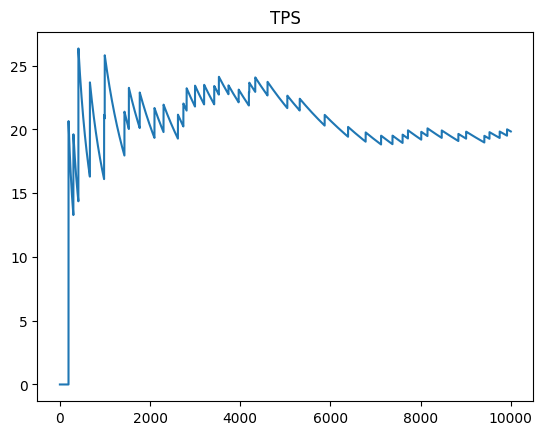

In [229]:
plt.plot(list(range(sim.params["run_time"])), sim.scalability["TPS"])
plt.title("TPS")
plt.show()

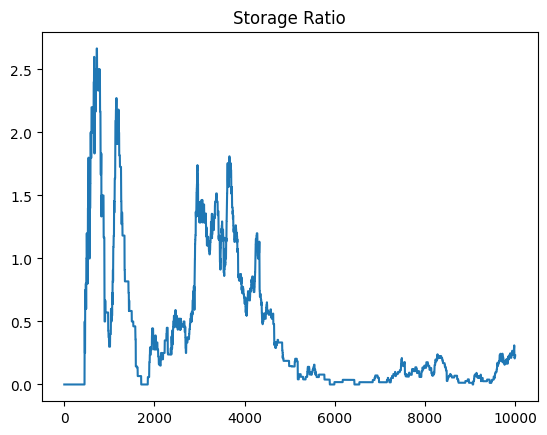

In [230]:
plt.plot(list(range(sim.params["run_time"])), sim.scalability["storage_ratio"])
plt.title("Storage Ratio")
plt.show()

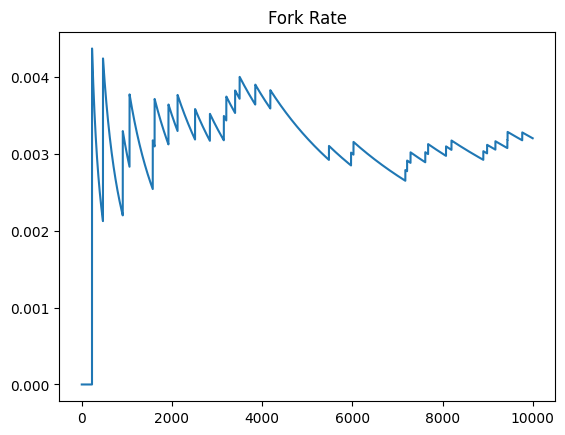

In [231]:
plt.plot(list(range(sim.params["run_time"])), sim.security["fork_rate"])
plt.title("Fork Rate")
plt.show()

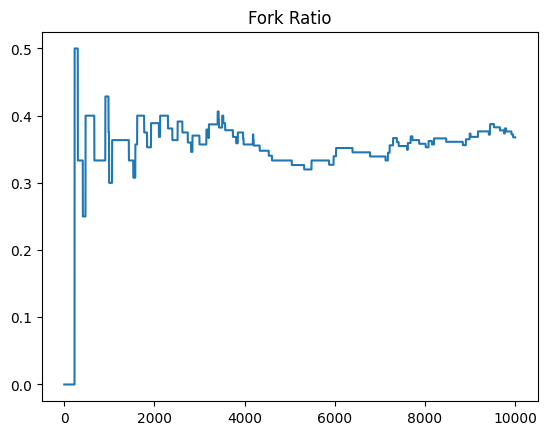

In [232]:
plt.plot(list(range(sim.params["run_time"])), sim.security["fork_ratio"])
plt.title("Fork Ratio")
plt.show()

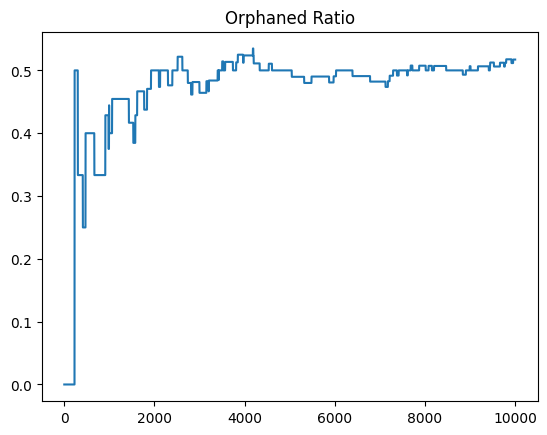

In [233]:
plt.plot(list(range(sim.params["run_time"])), sim.security["orphaned_ratio"])
plt.title("Orphaned Ratio")
plt.show()

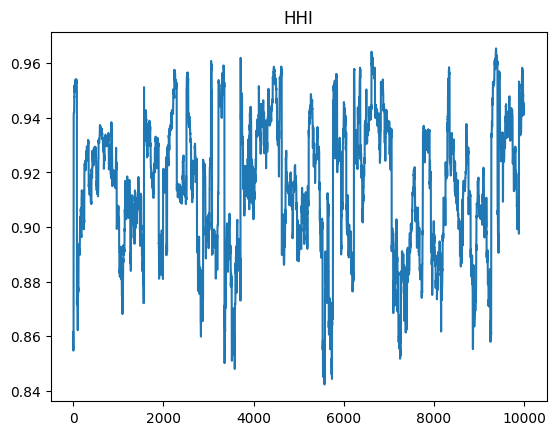

In [234]:
plt.plot(list(range(sim.params["run_time"])), sim.decentralization["HHI"])
plt.title("HHI")
plt.show()

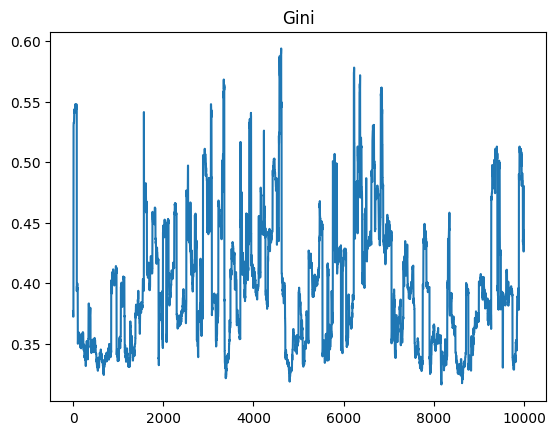

In [235]:
plt.plot(list(range(sim.params["run_time"])), sim.decentralization["gini"])
plt.title("Gini")
plt.show()

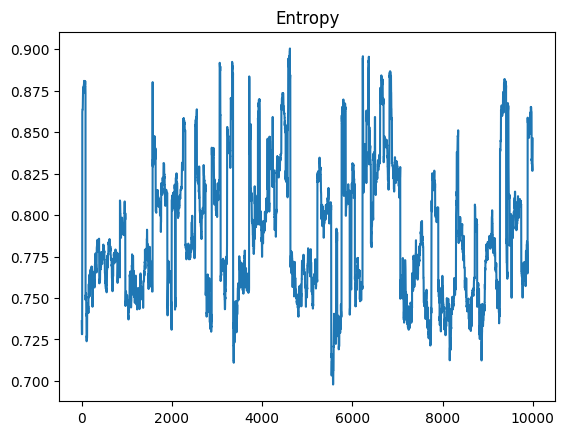

In [236]:
plt.plot(list(range(sim.params["run_time"])), sim.decentralization["entropy"])
plt.title("Entropy")
plt.show()

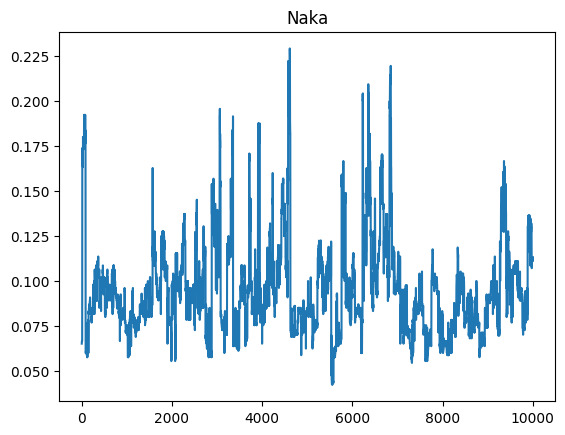

In [237]:
plt.plot(list(range(sim.params["run_time"])), sim.decentralization["naka"])
plt.title("Naka")
plt.show()